# Credit Card Fraud
Data: https://www.kaggle.com/mlg-ulb/creditcardfraud
        
Predicting Fraud

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Loading Data and Checking Dimensions

In [2]:
path = 'csv/creditcard.csv'
data = pd.read_csv(path)
df= pd.DataFrame(data)
print(df.shape)
print(df.columns)

(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


## Data Exploration
The below graph shows that the data is incedibly imbalanced. Cases of fraud = 1 on this graph.

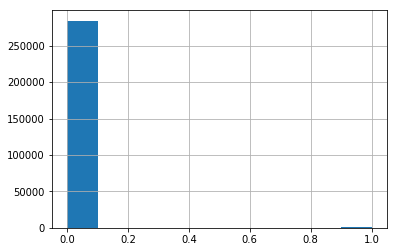

In [3]:
df['Class'].hist()
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

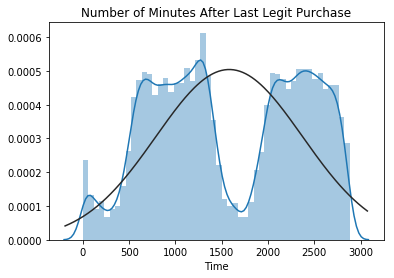

In [4]:
from scipy.stats import norm
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

sns.distplot(df['Time']/60, fit=norm)
plt.title('Number of Minutes After Last Legit Purchase')
plt.show

## Checking Correlation

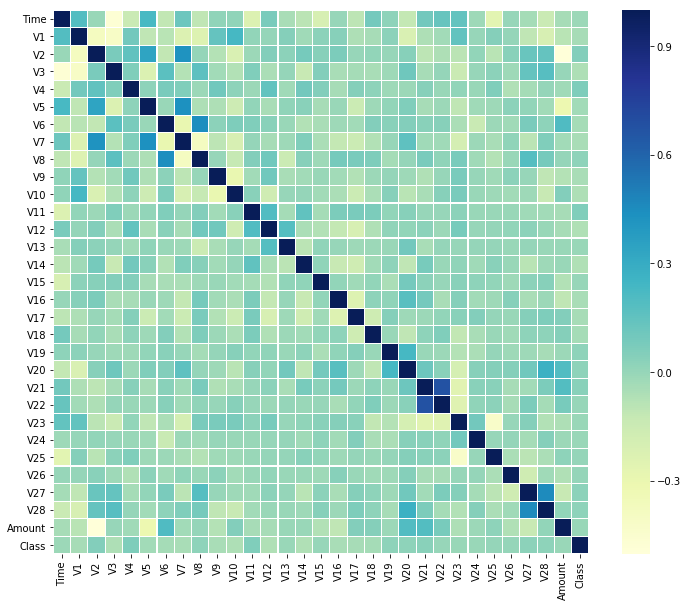

In [5]:
corrmat = df.corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, ax=ax, cmap="YlGnBu", linewidths=0.1)
plt.show()

## Method of Approach
Since this dataset is imbalanced the first step will be to create a new dataset with a fraud to no fraud ratio of 50%.

In [6]:
X = df.drop('Class', axis=1) 
y = df['Class']

In [7]:
from sklearn.model_selection import train_test_split

def data_split(features, labels):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

non_fraud_features = df.loc[df['Class'] == 0]
fraud_features = df.loc[df['Class'] == 1]

sample_class_0 = np.random.choice(non_fraud_features.index, y.sum(), replace=False)
sample_class_1 = np.random.choice(fraud_features.index, y.sum(), replace=False)

Selecting all the rows of fraud and an equal number of rows without fraud.

In [8]:
selection_1 = df.iloc[sample_class_0,:]
selection_2 = df.iloc[sample_class_1,:]

sample_df = selection_1.append(selection_2)

X_small = sample_df.drop('Class', axis=1)
y_small = sample_df['Class']

print('Number of Fraud Entries: {}'.format(len(sample_df.loc[df['Class'] == 1])))
print('Number of Non Fraud Entries: {}'.format(len(sample_df.loc[df['Class'] == 0])))

Number of Fraud Entries: 492
Number of Non Fraud Entries: 492


## Creating the Test Sets

In [9]:
X_train, X_test, y_train, y_test = data_split(X, y)
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = data_split(X_small, y_small)

## Testing Impact of Imbalanced Data
Below are two Random Forest Classifiers with the same paramaters tested on different sets.

Random Forest Classifier trained on balanced data.

In [10]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0, n_jobs=-1)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.9993679997191109

Random Forest Classifier trained on balanced data.

In [11]:
rfc_balanced = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0, n_jobs=-1)
rfc_balanced.fit(X_train_balanced, y_train_balanced)
rfc_balanced.score(X_test_balanced, y_test_balanced)

0.934010152284264

## Cross Validation

In [12]:
from sklearn.model_selection import cross_val_score

standard_score = cross_val_score(rfc, X_train, y_train, cv=10)
balanced_score = cross_val_score(rfc_balanced, X_train_balanced, y_train_balanced, cv=10)

In [13]:
print('Random Forest Classifier\n{}'.format(standard_score))
print('Random Forest Classifier with Balanced Data\n{}'.format(balanced_score))

Random Forest Classifier
[0.99938559 0.99938556 0.99947334 0.99934167 0.99929775 0.99938553
 0.9995611  0.99925386 0.9995611  0.99951721]
Random Forest Classifier with Balanced Data
[0.9375     0.95       0.9375     0.87341772 0.92307692 0.91025641
 0.97435897 0.92307692 0.93589744 0.93589744]


## Analysis
It would appear that the imbalanced data set scored higher. This is to be expected though since it could probably label every case as no fraud and still score higher than the balanced model. By doing further testing we can see that the larger dataset does more harm than good.

# Confusion Matrix

Here we can clearly see the negative impact that the unbalanced data had on the Random Forest Classifier. Both datasets had an equal number of fraudulent data points. However The balanced training set allowed for 16 more correct predictions. I would say that this model is performing very well. It had only missed two cases of fraud. By scoring both models on the smaller dataset we can see how well they really perform.

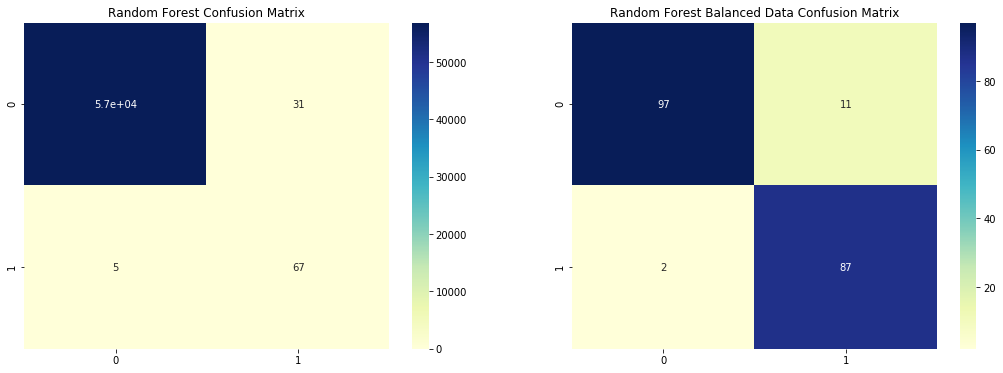

In [14]:
from sklearn.metrics import confusion_matrix

rfc_pred = rfc.predict(X_test)
balanced_pred = rfc_balanced.predict(X_test_balanced)

rfc_cm = confusion_matrix(rfc_pred, y_test)
balanced_cm = confusion_matrix(balanced_pred, y_test_balanced)


f, axes = plt.subplots(1, 2, figsize=(18,6))

sns.heatmap(rfc_cm, annot=True, cmap="YlGnBu", ax=axes[0])
sns.heatmap(balanced_cm, annot=True, cmap="YlGnBu", ax=axes[1])

axes[0].set_title('Random Forest Confusion Matrix')
axes[1].set_title('Random Forest Balanced Data Confusion Matrix')

plt.show()

## Comparing CV Scores on the Smaller Dataset.

In [15]:
print('RFC Score: {}'.format(rfc.score(X_test_balanced, y_test_balanced)))
print('RFC Balanced: {}'.format(rfc_balanced.score(X_test_balanced, y_test_balanced)))

RFC Score: 0.883248730964467
RFC Balanced: 0.934010152284264


## Creating and Comparing Models

Since this is a classification problem I will use the following models: Naive Bayes, Decision Tree, Random Forest, K Neareast Neighbors, Logistic Regression, Support Vector Machine, and Stochastic Gradient Descent.

Because of the negative impact of an imbalanced training set, I will continue to use the smaller balanced dataset for training and evaluation.

In [16]:
X_train, X_test, y_train, y_test = X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced

# Model Creation

## Grid Search CV Decision Tree

In [17]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


parameters = {'criterion':('gini', 'entropy'), 
              'min_samples_split':[2,3,5], 
              'max_depth':[6,9,12],
              'class_weight':('balanced', None),
              'presort':(False,True),
             }

dtr = DecisionTreeClassifier()
grid_search = GridSearchCV(dtr, parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_dtr = grid_search.best_estimator_
grid_dtr

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Grid Search CV K Nearest Neighbors

In [22]:
from sklearn.neighbors import KNeighborsClassifier


parameters = {'weights':('uniform', 'distance'), 
              'algorithm':('brute', 'kd_tree', 'ball_tree'), 
              'p':[1,2],
              'leaf_size':[20,40,60]
             }

knear = KNeighborsClassifier(n_jobs=-1)
k_grid = GridSearchCV(knear, parameters, cv=5, n_jobs=-1, iid=False)
k_grid.fit(X_train, y_train)
grid_knear = k_grid.best_estimator_

## Grid Search CV Random Forest Classifier

In [19]:
rfc = RandomForestClassifier()

parameters = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split':[2,3,10], 
    'max_depth':[6,9,15],
    'min_samples_leaf':[2,4,6],
    'min_samples_split': [2,4],
    'criterion' :['gini', 'entropy']
}

rfc_grid = GridSearchCV(rfc, parameters, cv=5, n_jobs=-1, iid=False)
rfc_grid.fit(X_train, y_train)
grid_rfc = rfc_grid.best_estimator_

## Grid Search CV Gradient Boosting Classifier

In [24]:
from xgboost import XGBClassifier


gbc = XGBClassifier(n_jobs=-1)

params = {
        'min_child_weight': [1, 5],
        'gamma': [1, 5],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.6, 1.0],
        'max_depth': [3,  5]
        }

gbc_grid = GridSearchCV(gbc, parameters, cv=5, n_jobs=-1, iid=False)
gbc_grid.fit(X_train, y_train)
grid_gbc = gbc_grid.best_estimator_

## More Models
Naive Bayes, Logistic Regression and Support Vector Machine.

In [25]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


bnb = BernoulliNB()
bnb.fit(X_train, y_train)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

svm = SVC(C=100, kernel='linear', gamma='auto')
svm.fit(X_train, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Model Scores

It appears that the Random Forest and Logistic Regression models are scoring the best.

In [26]:
print('Bernoulli Naive Bayes Score: {}'.format(bnb.score(X_test, y_test)))
print('Grid CV Decision Tree Score: {}'.format(grid_dtr.score(X_test, y_test)))
print('Grid CV Random Forest: {}'.format(grid_rfc.score(X_test, y_test)))
print('Grid CV K Neareast Neighbors: {}'.format(grid_knear.score(X_test, y_test)))
print('Logistic Regression Classification Score: {}'.format(log_reg.score(X_test, y_test)))
print('Support Vector Machine Score: {}'.format(svm.score(X_test, y_test)))
print('Gradient Boosting Classifier Score: {}'.format(grid_gbc.score(X_test, y_test)))

Bernoulli Naive Bayes Score: 0.9086294416243654
Grid CV Decision Tree Score: 0.9137055837563451
Grid CV Random Forest: 0.9238578680203046
Grid CV K Neareast Neighbors: 0.6751269035532995
Logistic Regression Classification Score: 0.9289340101522843
Support Vector Machine Score: 0.9187817258883249
Gradient Boosting Classifier Score: 0.9238578680203046


In [27]:
bnb_cv = cross_val_score(bnb, X_train, y_train, cv=5)
dtr_cv = cross_val_score(grid_dtr, X_train, y_train, cv=5)
rfc_cv = cross_val_score(grid_rfc, X_train, y_train, cv=5)
knn_cv = cross_val_score(grid_knear, X_train, y_train, cv=5)
log_cv = cross_val_score(log_reg, X_train, y_train, cv=5)
svm_cv = cross_val_score(svm, X_train, y_train, cv=5)
gbc_cv = cross_val_score(grid_gbc, X_train, y_train, cv=5)

## Cross Validation

Again Random forest and Logistic Regerssion are doing the best. However the Decision Tree model is showing promising results here. 

In [29]:
print('Bernoulli Naive Bayes\n{}\nMean: {}\n'.format(bnb_cv, bnb_cv.mean()))
print('Grid CV Decision Tree\n{}\nMean: {}\n'.format(dtr_cv, dtr_cv.mean()))
print('Grid CV Random Forest\n{}\nMean: {}\n'.format(rfc_cv, rfc_cv.mean()))
print('Grid CV KNN\n{}\nMean: {}\n'.format(knn_cv, knn_cv.mean()))
print('Logistic Regression Classification\n{}\nMean: {}\n'.format(log_cv, log_cv.mean()))
print('Support Vector Machine\n{}\nMean: {}\n'.format(svm_cv, svm_cv.mean()))
print('Gradient Boosting Classifier\n{}\nMean: {}\n'.format(gbc_cv, gbc_cv.mean()))

Bernoulli Naive Bayes
[0.91772152 0.89240506 0.88607595 0.9044586  0.92948718]
Mean: 0.9060296619717727

Grid CV Decision Tree
[0.93037975 0.92405063 0.89873418 0.92993631 0.93589744]
Mean: 0.9237996597183891

Grid CV Random Forest
[0.94936709 0.92405063 0.93670886 0.94267516 0.92948718]
Mean: 0.9364577842002658

Grid CV KNN
[0.64556962 0.68987342 0.73417722 0.64968153 0.6474359 ]
Mean: 0.6733475358525749

Logistic Regression Classification
[0.9556962  0.91139241 0.9556962  0.93630573 0.93589744]
Mean: 0.9389975957016189

Support Vector Machine
[0.87974684 0.91139241 0.87974684 0.87898089 0.90384615]
Mean: 0.8907426243030534

Gradient Boosting Classifier
[0.94936709 0.93037975 0.93670886 0.93630573 0.94230769]
Mean: 0.93901382419886



In [33]:
bnb_pred = bnb.predict(X_test)
dtr_pred = grid_dtr.predict(X_test)
rfc_pred = grid_rfc.predict(X_test)
knn_pred = grid_knear.predict(X_test)
log_pred = log_reg.predict(X_test)
svm_pred = svm.predict(X_test)
gbc_pred = grid_gbc.predict(X_test)

## Area Under the Receiver Operating Characteristic Curve 

In [34]:
from sklearn.metrics import roc_auc_score

bnb_roc = roc_auc_score(y_test, bnb_pred)
dtr_roc = roc_auc_score(y_test, dtr_pred)
rfc_roc = roc_auc_score(y_test, rfc_pred)
knn_roc = roc_auc_score(y_test, knn_pred)
log_roc = roc_auc_score(y_test, log_pred)
svm_roc = roc_auc_score(y_test, svm_pred)
gbc_roc = roc_auc_score(y_test, gbc_pred)

print(f'Naive Bayes: {bnb_roc}')
print(f'Decision Tree: {dtr_roc}')
print(f'Random Forest: {rfc_roc}')
print(f'K Nearest Neighbors: {knn_roc}')
print(f'Logistic Regression: {log_roc}')
print(f'Support Vector Machine: {svm_roc}')
print(f'Gradient Boosting Classifier: {gbc_roc}')

Naive Bayes: 0.9082663368377655
Decision Tree: 0.9135745207173779
Random Forest: 0.9236755308183879
K Nearest Neighbors: 0.6753762110904968
Logistic Regression: 0.9288806431663575
Support Vector Machine: 0.9183673469387755
Gradient Boosting Classifier: 0.923778602350031


### Creating a Dataframe for Graphing

In [35]:
graph_df = pd.DataFrame(columns=['result', 'model'])

rfc_df = pd.DataFrame(columns=['result', 'model'])
rfc_df['result'] = rfc_pred
rfc_df['model'] = 'Random Forest'

bnb_df = pd.DataFrame(columns=['result', 'model'])
bnb_df['result'] = bnb_pred
bnb_df['model'] = 'Naives Bayes'

dtr_df = pd.DataFrame(columns=['result', 'model'])
dtr_df['result'] = dtr_pred
dtr_df['model'] = 'Decision Tree'

act_df = pd.DataFrame(columns=['result', 'model'])
act_df['result'] = y_test
act_df['model'] = 'Actual'

knn_df = pd.DataFrame(columns=['result', 'model'])
knn_df['result'] = knn_pred
knn_df['model'] = 'K Neareast Neighbors'

log_df = pd.DataFrame(columns=['result', 'model'])
log_df['result'] = log_pred
log_df['model'] = 'Logistic Regression'

svm_df = pd.DataFrame(columns=['result', 'model'])
svm_df['result'] = svm_pred
svm_df['model'] = 'Support Vector Machine'

gbc_df = pd.DataFrame(columns=['result', 'model'])
gbc_df['result'] = gbc_pred
gbc_df['model'] = 'Gradient Boosting Classifier'


graph_df = graph_df.append(rfc_df)
graph_df = graph_df.append(bnb_df)
graph_df = graph_df.append(dtr_df)
graph_df = graph_df.append(act_df)
graph_df = graph_df.append(knn_df)
graph_df = graph_df.append(log_df)
graph_df = graph_df.append(svm_df)
graph_df = graph_df.append(gbc_df)

## Graphing Results

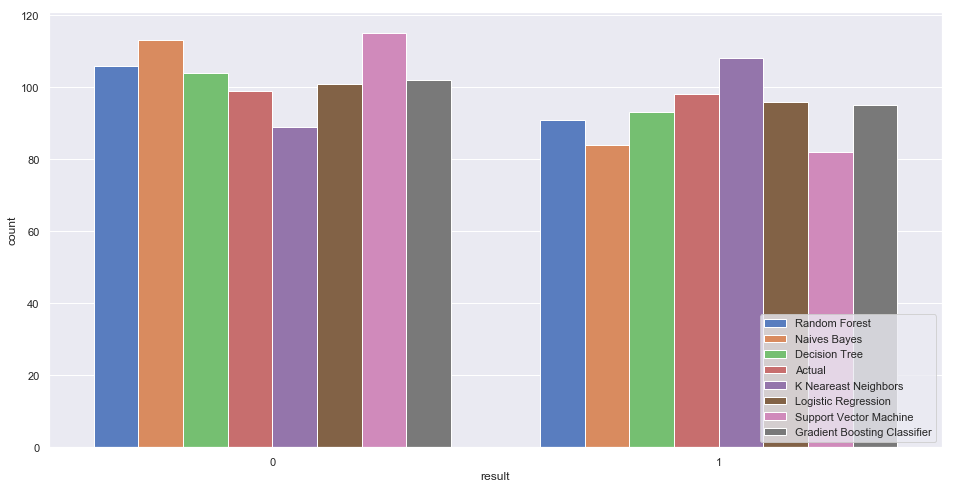

In [36]:
sns.set(style='darkgrid', color_codes=True)
plt.figure(figsize=(16, 8))
sns.countplot(x='result', hue='model', palette='muted', data=graph_df)
plt.legend(loc='lower right')
plt.show()

## Confusion Matrix Comparison

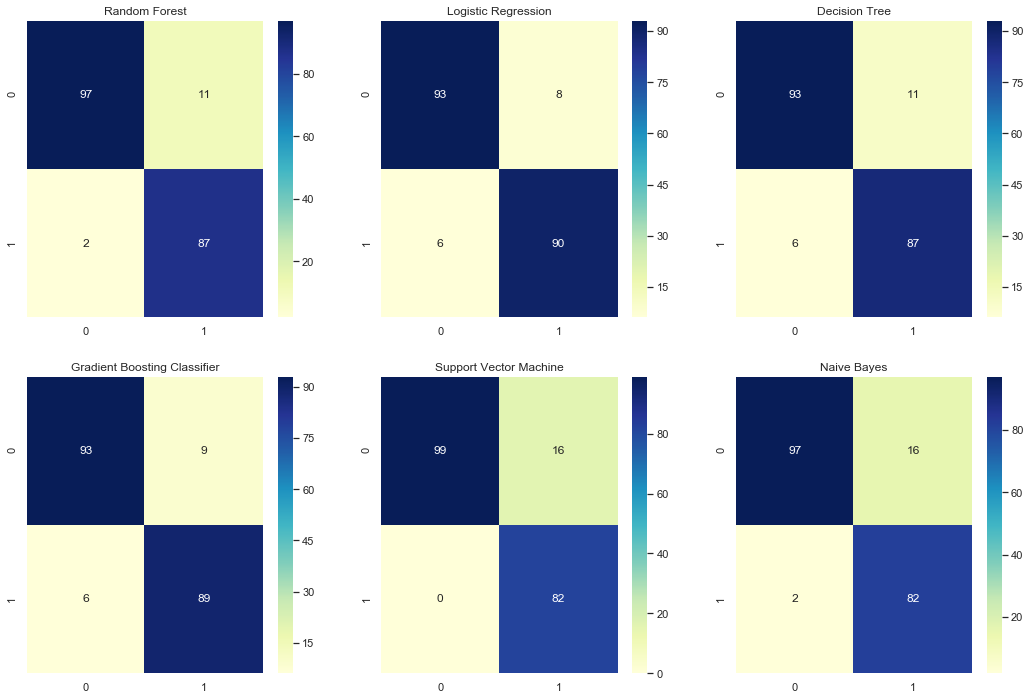

In [37]:
sns.set(style='dark')

rfc_cm = confusion_matrix(balanced_pred, y_test_balanced)
log_cm = confusion_matrix(log_pred, y_test)
dtr_cm = confusion_matrix(dtr_pred, y_test)
knn_cm = confusion_matrix(knn_pred, y_test)
svm_cm = confusion_matrix(svm_pred, y_test)
bnb_cm = confusion_matrix(bnb_pred, y_test)
gbc_cm = confusion_matrix(gbc_pred, y_test)


f, axes = plt.subplots(2, 3, figsize=(18,12))

sns.heatmap(rfc_cm, annot=True, cmap="YlGnBu", ax=axes[0, 0])
sns.heatmap(log_cm, annot=True, cmap="YlGnBu", ax=axes[0, 1])
sns.heatmap(dtr_cm, annot=True, cmap="YlGnBu", ax=axes[0, 2])
sns.heatmap(gbc_cm, annot=True, cmap="YlGnBu", ax=axes[1, 0])
sns.heatmap(svm_cm, annot=True, cmap="YlGnBu", ax=axes[1, 1])
sns.heatmap(bnb_cm, annot=True, cmap="YlGnBu", ax=axes[1, 2])

axes[0, 0].set_title('Random Forest')
axes[0, 1].set_title('Logistic Regression')
axes[0, 2].set_title('Decision Tree')
axes[1, 0].set_title('Gradient Boosting Classifier')
axes[1, 1].set_title('Support Vector Machine')
axes[1, 2].set_title('Naive Bayes')

plt.show()

# Classification Report

In [41]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1'] 

print('Bernoulli Naive Bayes Report\n {}'.format(classification_report(y_test, bnb_pred, target_names=target_names, labels=np.unique(bnb_pred))))
print('Grid CV Decision Tree Report\n {}'.format(classification_report(y_test, dtr_pred, target_names=target_names, labels=np.unique(dtr_pred))))
print('Grid CV Random Forest Report\n {}'.format(classification_report(y_test, rfc_pred, target_names=target_names, labels=np.unique(rfc_pred))))
print('Grid CV K Neareast Neighbors Report\n {}'.format(classification_report(y_test, knn_pred, target_names=target_names, labels=np.unique(knn_pred))))
print('Logistic Regression Classification Report\n {}'.format(classification_report(y_test, log_pred, target_names=target_names, labels=np.unique(log_pred))))
print('Support Vector Machine Report\n {}'.format(classification_report(y_test, svm_pred, target_names=target_names, labels=np.unique(svm_pred))))
print('Gradient Boosting Classifier Report\n {}'.format(classification_report(y_test, gbc_pred, target_names=target_names, labels=np.unique(gbc_pred))))

Bernoulli Naive Bayes Report
               precision    recall  f1-score   support

     class 0       0.86      0.98      0.92        99
     class 1       0.98      0.84      0.90        98

   micro avg       0.91      0.91      0.91       197
   macro avg       0.92      0.91      0.91       197
weighted avg       0.92      0.91      0.91       197

Grid CV Decision Tree Report
               precision    recall  f1-score   support

     class 0       0.89      0.94      0.92        99
     class 1       0.94      0.89      0.91        98

   micro avg       0.91      0.91      0.91       197
   macro avg       0.91      0.91      0.91       197
weighted avg       0.91      0.91      0.91       197

Grid CV Random Forest Report
               precision    recall  f1-score   support

     class 0       0.90      0.96      0.93        99
     class 1       0.96      0.89      0.92        98

   micro avg       0.92      0.92      0.92       197
   macro avg       0.93      0.92     

# Final Analysis
Out of the top 3 models with these current results I would use the decision tree or logistic regression. While the random forest was the most accurate it missed the most cases of fraud which is very important. While the support vector machine didn't score the best and had many false positives. It however didn't miss a single case of fraud and would prove to be a useful model. By implementing ensembling it could be possible to not miss any cases of fraud and lower the false positives.